# Electricity_Forecasting
參考文件: https://docs.google.com/document/d/11G_SqvtPEQD4cqCEfBCpBS4L8BeiVIwlNoXYy7oSdKM/edit  
https://data.gov.tw/dataset/14718

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import dcor as dcor
import minepy as mp
# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True' # To prevent kernel from dying when fitting
import xgboost as xgb
from sklearn.metrics import mean_squared_error,mean_absolute_error
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## 參數

In [2]:
n_days = list(range(2, 201)) # number of days needed for prediction
init_n_days = 118
n_tests = 15 # numbers of days reserved for testing
start_offset = 400

## 整理　dataset

In [3]:
'''
load data
'''

raw_data = []
raw_data = pd.DataFrame(raw_data)

holiday_data = []
holiday_data = pd.DataFrame(holiday_data)

file = '近三年每日尖峰備轉容量率.csv'
raw_data_new = pd.read_csv(file)
raw_data_new = pd.DataFrame(raw_data_new)
raw_data_new = raw_data_new.loc[:,['日期','備轉容量(萬瓩)', '備轉容量率(%)']]
# print(raw_data_new)
raw_data_new.columns=['date','op_reserve', 'op_reserve_ratio']
raw_data_new['date']= pd.to_datetime(raw_data_new['date'])

# change datetime format
'''
for index in range(len(raw_data_new['date'])):
    index_time = str(raw_data_new['date'][index]).split('.')[-1][1:]
    # print(index_time)
    time_change = datetime.strptime(index_time,"%Y%m%d")
    raw_data_new['date'][index] = time_change
'''

raw_data_new['year']= pd.DatetimeIndex(raw_data_new['date']).year
raw_data_new['month']= pd.DatetimeIndex(raw_data_new['date']).month
raw_data_new['day']= pd.DatetimeIndex(raw_data_new['date']).day
raw_data_new['day_of_week'] = raw_data_new['date'].dt.dayofweek

raw_data = pd.concat([raw_data, raw_data_new])

file =  '台灣電力公司_本年度每日尖峰備轉容量率.csv'
raw_data_new = pd.read_csv(file)
raw_data_new = pd.DataFrame(raw_data_new)
raw_data_new = raw_data_new.loc[:,[True,True,True]]
raw_data_new.columns = ['date', 'op_reserve', 'op_reserve_ratio']
# print(raw_data_new)
# print(type(raw_data_new['date'][0]))
raw_data_new['date'] = pd.to_datetime(raw_data_new['date'])
raw_data_new['year']= pd.DatetimeIndex(raw_data_new['date']).year
raw_data_new['month']= pd.DatetimeIndex(raw_data_new['date']).month
raw_data_new['day']= pd.DatetimeIndex(raw_data_new['date']).day
raw_data_new['day_of_week'] = raw_data_new['date'].dt.dayofweek

raw_data = pd.concat([raw_data,raw_data_new])

file = '108年中華民國政府行政機關辦公日曆表.csv'
raw_data_new = pd.read_csv(file)
raw_data_new = pd.DataFrame(raw_data_new)
raw_data_new = raw_data_new.loc[:,[True, False, True, False]]
raw_data_new.columns=['date','is_holiday']
for idx, date in enumerate(raw_data_new['date']):
    date = str(raw_data_new['date'][idx])
    raw_data_new['date'][idx] = date[:2] + '/'.join(date[i:i+2] for i in range(2, len(date), 2))
raw_data_new['date']= pd.to_datetime(raw_data_new['date'])
raw_data_new['year']= pd.DatetimeIndex(raw_data_new['date']).year
raw_data_new['month']= pd.DatetimeIndex(raw_data_new['date']).month
raw_data_new['day']= pd.DatetimeIndex(raw_data_new['date']).day
raw_data_new['day_of_week'] = raw_data_new['date'].dt.dayofweek

holiday_data = pd.concat([holiday_data, raw_data_new])

file = '109年中華民國政府行政機關辦公日曆表.csv'
raw_data_new = pd.read_csv(file)
raw_data_new = pd.DataFrame(raw_data_new)
raw_data_new = raw_data_new.loc[:,[True, False, True, False]]
raw_data_new.columns=['date','is_holiday']
for idx, date in enumerate(raw_data_new['date']):
    date = str(raw_data_new['date'][idx])
    raw_data_new['date'][idx] = date[:2] + '/'.join(date[i:i+2] for i in range(2, len(date), 2))
raw_data_new['date']= pd.to_datetime(raw_data_new['date'])
raw_data_new['year']= pd.DatetimeIndex(raw_data_new['date']).year
raw_data_new['month']= pd.DatetimeIndex(raw_data_new['date']).month
raw_data_new['day']= pd.DatetimeIndex(raw_data_new['date']).day
raw_data_new['day_of_week'] = raw_data_new['date'].dt.dayofweek

holiday_data = pd.concat([holiday_data, raw_data_new])

file = '110中華民國政府行政機關辦公日曆表.csv'
raw_data_new = pd.read_csv(file)
raw_data_new = pd.DataFrame(raw_data_new)
raw_data_new = raw_data_new.loc[:,[True, False, True, False]]
raw_data_new.columns=['date','is_holiday']
for idx, date in enumerate(raw_data_new['date']):
    date = str(raw_data_new['date'][idx])
    raw_data_new['date'][idx] = date[:2] + '/'.join(date[i:i+2] for i in range(2, len(date), 2))
raw_data_new['date']= pd.to_datetime(raw_data_new['date'])
raw_data_new['year']= pd.DatetimeIndex(raw_data_new['date']).year
raw_data_new['month']= pd.DatetimeIndex(raw_data_new['date']).month
raw_data_new['day']= pd.DatetimeIndex(raw_data_new['date']).day
raw_data_new['day_of_week'] = raw_data_new['date'].dt.dayofweek

holiday_data = pd.concat([holiday_data, raw_data_new])

file = '111年中華民國政府行政機關辦公日曆表.csv'
raw_data_new = pd.read_csv(file)
raw_data_new = pd.DataFrame(raw_data_new)
raw_data_new = raw_data_new.loc[:,[True, False, True, False]]
raw_data_new.columns=['date','is_holiday']
for idx, date in enumerate(raw_data_new['date']):
    date = str(raw_data_new['date'][idx])
    raw_data_new['date'][idx] = date[:2] + '/'.join(date[i:i+2] for i in range(2, len(date), 2))
raw_data_new['date']= pd.to_datetime(raw_data_new['date'])
raw_data_new['year']= pd.DatetimeIndex(raw_data_new['date']).year
raw_data_new['month']= pd.DatetimeIndex(raw_data_new['date']).month
raw_data_new['day']= pd.DatetimeIndex(raw_data_new['date']).day
raw_data_new['day_of_week'] = raw_data_new['date'].dt.dayofweek

holiday_data = pd.concat([holiday_data, raw_data_new])

raw_data = holiday_data.merge(raw_data)

'''
Trim outliers & convert unit
'''
# FIXME: use difference instead?
op_reserve_mean = round(float(raw_data['op_reserve'].mean()), 1)
for i, op_reserve in enumerate(raw_data['op_reserve']):
#     if op_reserve > 650:
#         raw_data['op_reserve'][i] = 650
#     elif op_reserve < 250:
#         raw_data['op_reserve'][i] = 250
    raw_data['op_reserve'][i] = raw_data['op_reserve'][i] * 10
    
'''split training set and testing set'''
train = raw_data[start_offset:-n_tests]
test = raw_data[-n_tests:]

# train.set_index('date',inplace=True)
# test.set_index('date',inplace=True)
# print("train:\n",train)
# print("test:\n",test)
# raw_data.tail(n=50)

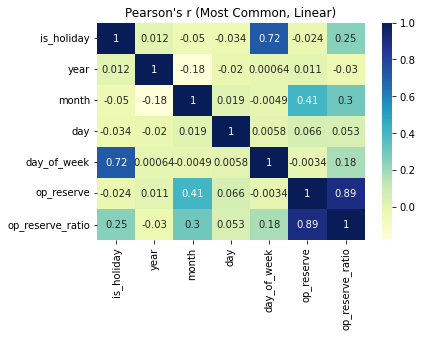

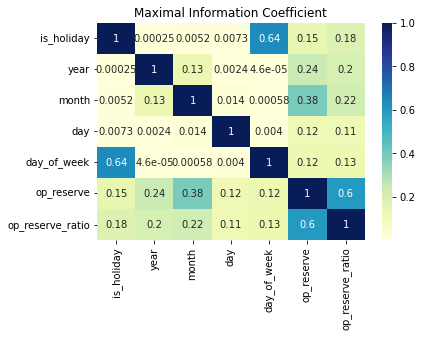

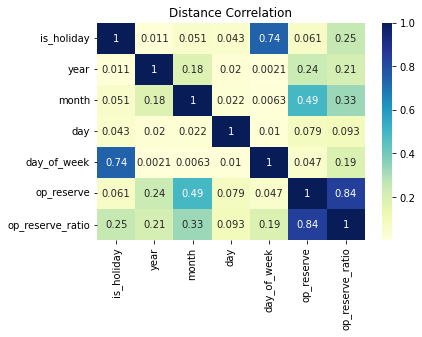

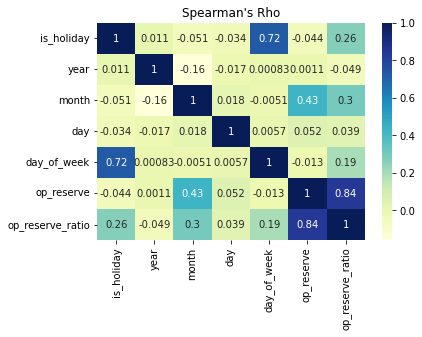

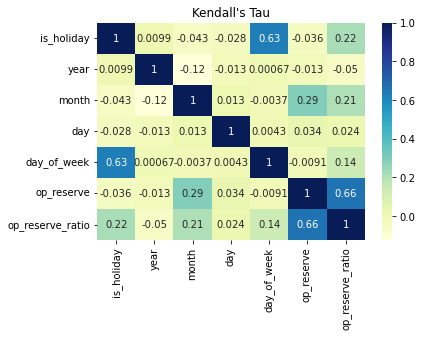

In [4]:
'''
Pearson's r
'''
sns.heatmap(raw_data.corr(), annot=True, cmap="YlGnBu")
plt.title('Pearson\'s r (Most Common, Linear)')
plt.show()
# pearson_r_matrix = raw_data.corr()
# for i in pearson_r_matrix:
#     for j in pearson_r_matrix:
#         pearson_r_matrix[i][j], dummy = sp.stats.pearsonr(raw_data[i].to_numpy(), raw_data[j].to_numpy())
# sns.heatmap(pearson_r_matrix, annot=True, cmap="YlGnBu")
# plt.show()
# '''
# @Spatial Distance: just 1 - corr()
# '''
# spatial_distance_matrix = raw_data.corr()
# for i in spatial_distance_matrix:
#     for j in spatial_distance_matrix:
#         spatial_distance_matrix[i][j] = 1 - sp.spatial.distance.correlation(raw_data[i], raw_data[j])
# sns.heatmap(spatial_distance_matrix, annot=True, cmap="YlGnBu")
# plt.show()
'''
@Maximal Information Coefficient
'''
mic_matrix = raw_data.corr()
raw_data_2d = np.delete(np.transpose(raw_data.to_numpy()), 0, 0)
mic_matrix_raw = mp.pstats(raw_data_2d)[0] #[0]: mic, [1]: tic
it = 0
for it1, i in enumerate(mic_matrix):
    for it2, j in enumerate(mic_matrix):
        if i != j:
            if it1 < it2:
                mic_matrix[i][j] = mic_matrix_raw[it]
                it += 1
            else:
                mic_matrix[i][j] = mic_matrix[j][i]
        else:
            mic_matrix[i][j] = 1

sns.heatmap(mic_matrix, annot=True, cmap="YlGnBu")
plt.title('Maximal Information Coefficient')
plt.show()
'''
Distance Correlation
'''
distance_correlation_matrix = raw_data.corr()
for i in distance_correlation_matrix:
    for j in distance_correlation_matrix:
        distance_correlation_matrix[i][j] = dcor.distance_correlation(raw_data[i], raw_data[j])
sns.heatmap(distance_correlation_matrix, annot=True, cmap="YlGnBu")
plt.title('Distance Correlation')
plt.show()
'''
@Spearman's Rho
'''
spearman_r_matrix = raw_data.corr()
for i in spearman_r_matrix:
    for j in spearman_r_matrix:
        spearman_r_matrix[i][j], dummy = sp.stats.spearmanr(raw_data[i].to_numpy(), raw_data[j].to_numpy())
sns.heatmap(spearman_r_matrix, annot=True, cmap="YlGnBu")
plt.title('Spearman\'s Rho')
plt.show()

'''
@Kendall's Tau
'''
kendall_tau_matrix = raw_data.corr()
for i in kendall_tau_matrix:
    for j in kendall_tau_matrix:
        kendall_tau_matrix[i][j], dummy = sp.stats.kendalltau(raw_data[i], raw_data[j])
sns.heatmap(kendall_tau_matrix, annot=True, cmap="YlGnBu")
plt.title('Kendall\'s Tau')
plt.show()

px.box(raw_data, x="day", y="op_reserve", points="all").show()
px.box(raw_data, x="month", y="op_reserve", points="all").show()
px.box(raw_data, x="day_of_week", y="op_reserve", points="all").show()
px.box(raw_data, x="is_holiday", y="op_reserve", points="all").show()
px.box(raw_data, x="is_holiday", y="op_reserve_ratio", points="all").show()

In [5]:
file = '台灣電力公司_過去電力供需資訊2021.csv'
raw_data_new = pd.read_csv(file)
raw_data_new = pd.DataFrame(raw_data_new)
raw_data_new = raw_data_new.loc[:,['日期', '淨尖峰供電能力(MW)', '尖峰負載(MW)', '備轉容量(MW)', '備轉容量率(%)']]
raw_data_new.columns=['date', 'net peak', 'peak', 'op_reserve', 'op_reserve_ratio']
for idx, date in enumerate(raw_data_new['date']):
    date = str(raw_data_new['date'][idx])
    raw_data_new['date'][idx] = date[:2] + '/'.join(date[i:i+2] for i in range(2, len(date), 2))
raw_data_new['date']= pd.to_datetime(raw_data_new['date'])
raw_data_new['year']= pd.DatetimeIndex(raw_data_new['date']).year
raw_data_new['month']= pd.DatetimeIndex(raw_data_new['date']).month
raw_data_new['day']= pd.DatetimeIndex(raw_data_new['date']).day
raw_data_new['day_of_week'] = raw_data_new['date'].dt.dayofweek
raw_data_new['date']= pd.to_datetime(raw_data_new['date'])
raw_data_new = holiday_data.merge(raw_data_new)
# raw_data_new.head()
px.scatter(raw_data_new, x="net peak", y="peak").show()
px.box(raw_data_new, x="is_holiday", y="net peak", points="all").show()
# raw_data_new.boxplot(by='is_holiday', column='net peak', figsize=(26,8))

<AxesSubplot:xlabel='date'>

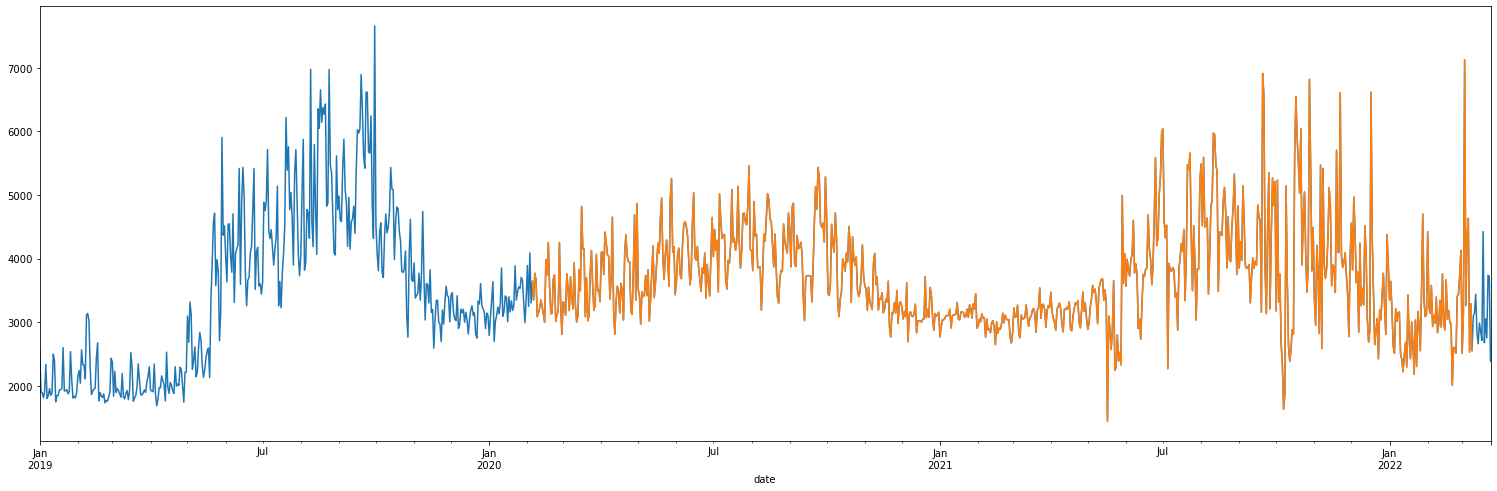

In [6]:
raw_data.set_index('date',inplace=True)
raw_data['op_reserve'].plot(label='first_data', figsize=(26,8))
# raw_data = raw_data.reset_index(level=0)
train_tmp = train[:]
train_tmp.set_index('date',inplace=True)
train_tmp['op_reserve'].plot(label='first_data', figsize=(26,8))

## XGBoost 演算法
eXtreme Gradient Boosting

### 使用當天的日期、前 n 天的 op_reserve

#### Initialization

In [7]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

train.tail()

date  is_holiday  year  month  day  day_of_week  op_reserve  \
1159 2022-03-05           2  2022      3    5            5      4338.0   
1160 2022-03-06           2  2022      3    6            6      4632.0   
1161 2022-03-07           0  2022      3    7            0      2527.0   
1162 2022-03-08           0  2022      3    8            1      3290.0   
1163 2022-03-09           0  2022      3    9            2      2550.0   

      op_reserve_ratio  
1159             15.83  
1160             17.57  
1161              8.50  
1162             10.99  
1163              8.42

#### Training / Fitting

In [8]:
def add_day_of_data_from_record(X, raw_data, i): # lists are mutable
#     X.extend([raw_data.iloc[i]['year'], raw_data.iloc[i]['month'], raw_data.iloc[i]['day'], raw_data.iloc[i]['day_of_week']])
#     X.extend([raw_data.index[i], raw_data.iloc[i]['day_of_week']])
#     X.extend([raw_data.iloc[i]['month'], raw_data.iloc[i]['day'], raw_data.iloc[i]['day_of_week']])
    X.extend([raw_data.iloc[i]['year'], raw_data.iloc[i]['month'], raw_data.iloc[i]['day'], raw_data.iloc[i]['day_of_week'], raw_data.iloc[i]['is_holiday']])

def add_day_before_data_from_record(X, raw_data, i):
    X.extend([raw_data.iloc[i]['op_reserve'], raw_data.iloc[i]['op_reserve_ratio']])
#     X.append(raw_data.iloc[i]['op_reserve'])
    
def generate_training_data(training_data, n_days):
    op_reserve_mean = round(float(training_data['op_reserve'].mean()), 1)
    X_train_list = []
    Y_train_list = []
    for i in range(n_days, len(training_data['date'])):
        X = []
        Y = []
        # add today info
        add_day_of_data_from_record(X, training_data, i)
        # add last n days op_reserve
        for last_day_index in range(1, n_days + 1):
            last_day = i - last_day_index 
            add_day_before_data_from_record(X, training_data, last_day)
    #         if last_day >= 0:
    #             X.append(training_data.iloc[last_day]['op_reserve'])
    #         else:
    #             X.append(op_reserve_mean)
        # add today op_reserve for verification
        Y.append(training_data.iloc[i]['op_reserve'])
        X_train_list.append(X)
        Y_train_list.append(Y)

    '''
    change list to np-array
    '''
    X_train_list = np.array(X_train_list)
    Y_train_list = np.array(Y_train_list)
    
    return X_train_list, Y_train_list

X_train_list, Y_train_list = generate_training_data(train, init_n_days)

In [9]:
xgb_model.fit(X_train_list, Y_train_list, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [10]:
def train_predictions_rmse(X_train_list):
    y_train_pred = xgb_model.predict(X_train_list)
    rmse=mean_squared_error(Y_train_list, y_train_pred, squared=False)
    return rmse, y_train_pred

rmse, y_train_pred = train_predictions_rmse(X_train_list)
print(len(y_train_pred), 'predictions')
print('RMSE:', rmse)

646 predictions
RMSE: 0.027108841089406633


In [11]:
result_df = train[['date','op_reserve']]
result_df = result_df.iloc[len(train) - len(y_train_pred):, :]
result_df['op_reserve_predict'] = y_train_pred

result_df.head()

date  op_reserve  op_reserve_predict
518 2020-06-02    4070.865         4070.855469
519 2020-06-03    4162.550         4162.523926
520 2020-06-04    3753.820         3753.827637
521 2020-06-05    3682.700         3682.674561
522 2020-06-06    4239.700         4239.711914

In [12]:
result_df.set_index('date',inplace=True)
result_df.head()

op_reserve  op_reserve_predict
date                                      
2020-06-02    4070.865         4070.855469
2020-06-03    4162.550         4162.523926
2020-06-04    3753.820         3753.827637
2020-06-05    3682.700         3682.674561
2020-06-06    4239.700         4239.711914

<AxesSubplot:xlabel='date'>

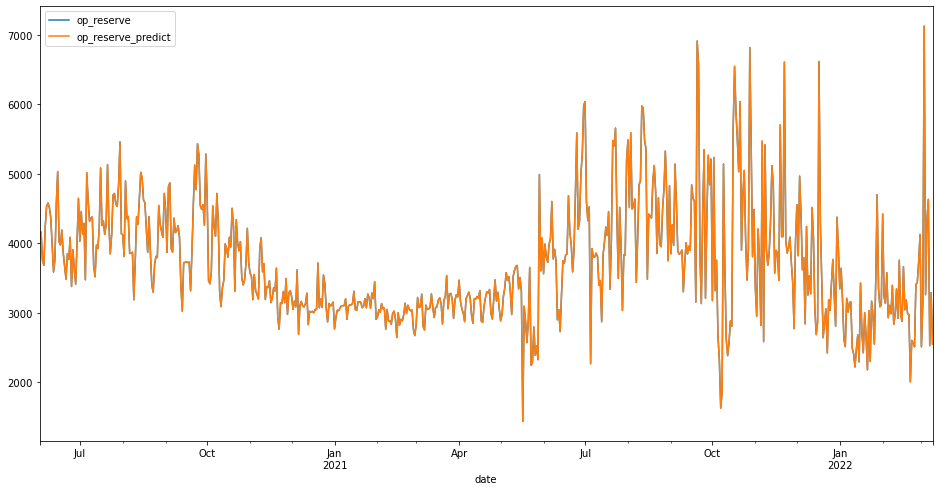

In [13]:
result_df.plot(label='first_data', figsize=(16,8))

In [14]:
result_df = result_df.reset_index(level=0)
result_df.head()

date  op_reserve  op_reserve_predict
0 2020-06-02    4070.865         4070.855469
1 2020-06-03    4162.550         4162.523926
2 2020-06-04    3753.820         3753.827637
3 2020-06-05    3682.700         3682.674561
4 2020-06-06    4239.700         4239.711914

#### Testing XGBoost Model

In [15]:
'''
prepare test data
'''

def generate_testing_data_and_predictions(training_data, testing_data, n_days):
    Y_test_list =[]
    y_test_pred_list =[]
    op_reserve_mean = round(float(training_data['op_reserve'].mean()),1)

    for i in range(len(testing_data['date'])):
        X_test_list =[]
        X = []
        Y = []
        # add today info
        add_day_of_data_from_record(X, testing_data, i)
        # add data from prev n days
        for last_day_index in range(1, n_days + 1):
            last_day = i - last_day_index
            # if not in given data, use real data
            if last_day >= 0:
                add_day_before_data_from_record(X, testing_data, last_day)
            #       X.append(y_test_pred_list[last_day])
            # if in given data, take in from training data list
            else:
                add_day_before_data_from_record(X, training_data, last_day)
                # print(training_data.iloc[last_day]['op_reserve'])
            '''
            The original code is `training_data.iloc[-last_day]['caoacity']` but since last_day is already negative, the minus operated isn't needed.
            '''
        # save the correct answer for later check
        Y.append(testing_data.iloc[i]['op_reserve'])
        X_test_list.append(X)
        Y_test_list.append(Y)
        # predict the result, and add it to y_test_pred_list
        # it will be needed in the next iteration on
        y_test_pred = xgb_model.predict(X_test_list)
        y_test_pred_list.append(round(y_test_pred[0],1))

    # change list to np array
    X_test_list = np.array(X_test_list)
    Y_test_list = np.array(Y_test_list)
    return X_test_list, Y_test_list, y_test_pred_list
    
X_test_list, Y_test_list, y_test_pred_list = generate_testing_data_and_predictions(train, test, init_n_days)

In [16]:
'''
test the result
'''
def test_predictions_rmse(Y_test_list, y_test_pred_list):
    return mean_squared_error(Y_test_list, y_test_pred_list, squared=False)

print(len(y_test_pred_list))
rmse = test_predictions_rmse(Y_test_list, y_test_pred_list)
print('RMSE =', rmse)

15
RMSE = 622.5877900194098


In [17]:
test_result_df = test[['date','op_reserve']]
test_result_df['op_reserve_predict'] = y_test_pred_list
test_result_df.head()

date  op_reserve  op_reserve_predict
1164 2022-03-10      3088.0         3336.699951
1165 2022-03-11      3148.0         3247.399902
1166 2022-03-12      3438.0         3360.500000
1167 2022-03-13      2839.0         3576.100098
1168 2022-03-14      2659.0         2881.000000

<AxesSubplot:xlabel='date'>

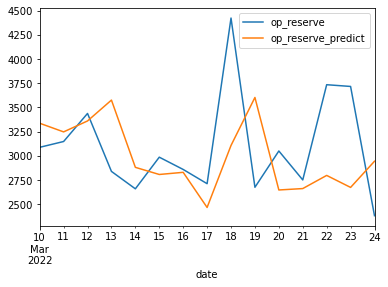

In [18]:
test_result_df.set_index('date',inplace=True)
test_result_df.plot(label='test_data') # , figsize=(16,8)

##### Master Cell: Test Different `n_days` values

2 : 598.5619756396544
3 : 641.4084279977276
4 : 652.7185600552733
5 : 703.1895520646043
6 : 705.6593980945362
7 : 629.57416406174
8 : 635.1840629714112
9 : 652.4197205538635
10 : 734.9833268844833
11 : 666.3523268174903
12 : 678.8136203158452
13 : 713.7754797973244
14 : 746.5441132864735
15 : 694.3954577567877
16 : 743.5982130325046
17 : 591.9984494751604
18 : 852.4489584220568
19 : 712.3268240641052
20 : 693.7850188355768
21 : 813.9646744972607
22 : 682.7550392417711
23 : 655.6382391592114
24 : 771.7625234468254
25 : 749.1128587977583
26 : 637.9720920089659
27 : 783.2415419198198
28 : 653.2506086511742
29 : 743.5939544052251
30 : 654.24259151835
31 : 648.3282388816525
32 : 612.9375986497703
33 : 632.048975345805
34 : 688.3984057674413
35 : 684.0885653777618
36 : 653.6745469393869
37 : 605.9108931948605
38 : 631.6675240056833
39 : 659.0544986316926
40 : 670.518507706601
41 : 663.0199778257805
42 : 512.4656442683176
43 : 578.56953676663
44 : 534.443998066838
45 : 588.3781459743052
46 : 

<AxesSubplot:xlabel='n_days'>

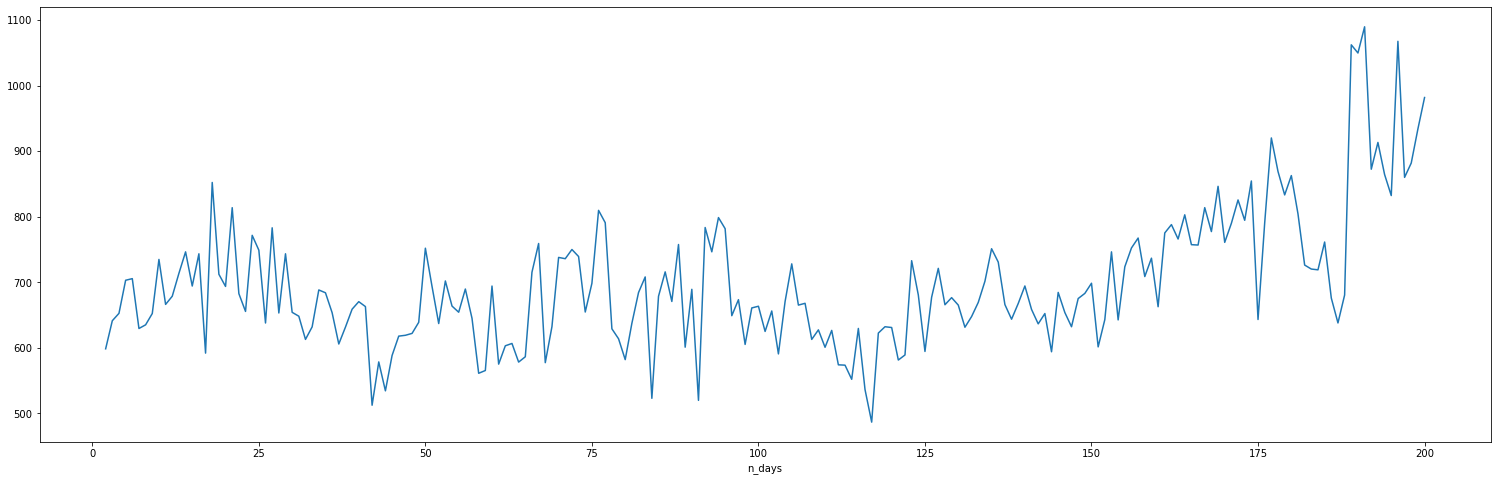

In [19]:
min_rmse = rmse
best_n_days = n_days[0]
rmse_dist = pd.DataFrame(columns=['n_days', 'rmse'])
for i, n in enumerate(n_days):
    X_train_list, Y_train_list = generate_training_data(train, n)
    xgb_model.fit(X_train_list, Y_train_list, verbose=False)
    X_test_list, Y_test_list, y_test_pred_list = generate_testing_data_and_predictions(train, test, n)
    rmse = test_predictions_rmse(Y_test_list, y_test_pred_list)
    if rmse < min_rmse:
        best_n_days = n
        min_rmse = rmse
    print(n, ':', rmse)
    rmse_dist = rmse_dist.append(pd.DataFrame({'n_days': [n], 'rmse': [rmse]})) #append doesn't work IN PLACE

print("Best n_days: ", best_n_days)
print("Minimum RMSE: ", min_rmse)

rmse_dist.set_index('n_days',inplace=True)
rmse_dist['rmse'].plot(label='rmse', figsize=(26,8))

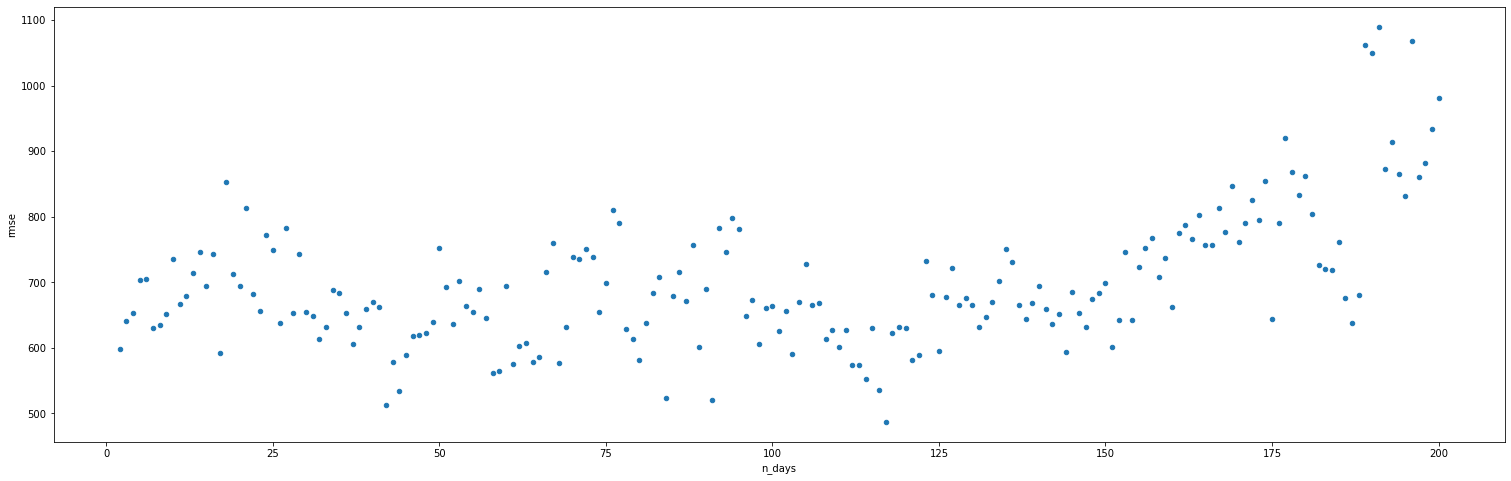

In [20]:
rmse_dist = rmse_dist.reset_index(level=0)
rmse_dist.plot.scatter(x='n_days', y='rmse', figsize=(26,8))
px.scatter(rmse_dist, x="n_days", y="rmse").show()
# rmse_dist.plot.line(x='n_days', y='rmse', figsize=(26,8))

### 只用 當天日期


In [21]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

In [22]:
train.tail()

date  is_holiday  year  month  day  day_of_week  op_reserve  \
1159 2022-03-05           2  2022      3    5            5      4338.0   
1160 2022-03-06           2  2022      3    6            6      4632.0   
1161 2022-03-07           0  2022      3    7            0      2527.0   
1162 2022-03-08           0  2022      3    8            1      3290.0   
1163 2022-03-09           0  2022      3    9            2      2550.0   

      op_reserve_ratio  
1159             15.83  
1160             17.57  
1161              8.50  
1162             10.99  
1163              8.42

#### train the xgb boost model

In [23]:
X_train_list =[]
Y_train_list =[]
for i in range(len(train['date'])):
      X = []
      Y = []
      # only add today info
      X.extend([train.iloc[i]['year'],train.iloc[i]['month'],train.iloc[i]['day'],train.iloc[i]['day_of_week'], train.iloc[i]['is_holiday']])
      # save the correct answer 
      Y.append(train.iloc[i]['op_reserve'])
      X_train_list.append(X)
      Y_train_list.append(Y)
# change list to np array
X_train_list = np.array(X_train_list)
Y_train_list = np.array(Y_train_list)

In [24]:
xgb_model.fit(X_train_list, Y_train_list)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [25]:
y_train_pred = xgb_model.predict(X_train_list)
print(len(y_train_pred))
rmse=mean_squared_error(Y_train_list, y_train_pred, squared=False)
print('RMSE =', rmse)

764
RMSE = 76.98472412801127


In [26]:
result_df = train[['date','op_reserve']]
result_df = result_df.iloc[len(train) - len(y_train_pred):, :]
result_df['op_reserve_predict'] = y_train_pred
result_df.head()

date  op_reserve  op_reserve_predict
400 2020-02-05      3642.6         3644.784668
401 2020-02-06      3346.9         3300.705078
402 2020-02-07      3767.2         3745.517822
403 2020-02-08      3660.2         3652.327881
404 2020-02-09      3084.4         3116.503418

In [27]:
result_df.set_index('date',inplace=True)

In [28]:
result_df.head()

op_reserve  op_reserve_predict
date                                      
2020-02-05      3642.6         3644.784668
2020-02-06      3346.9         3300.705078
2020-02-07      3767.2         3745.517822
2020-02-08      3660.2         3652.327881
2020-02-09      3084.4         3116.503418

<AxesSubplot:xlabel='date'>

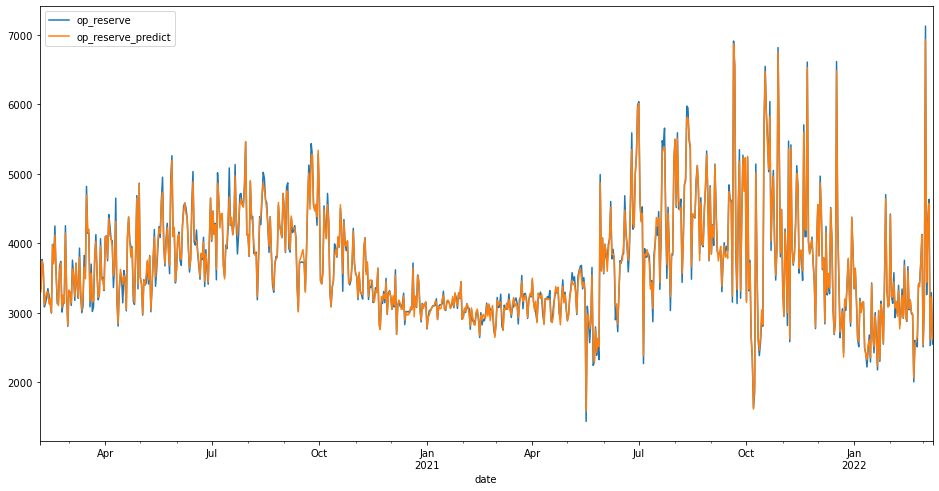

In [29]:
result_df.plot(label='first_data', figsize=(16,8))

In [30]:
result_df = result_df.reset_index(level=0)
result_df.head()

date  op_reserve  op_reserve_predict
0 2020-02-05      3642.6         3644.784668
1 2020-02-06      3346.9         3300.705078
2 2020-02-07      3767.2         3745.517822
3 2020-02-08      3660.2         3652.327881
4 2020-02-09      3084.4         3116.503418

#### test the xgb boost model

In [31]:
X_test_list =[]
Y_test_list =[]

for i in range(len(test['date'])):
  X = []
  Y = []
  # only today info
  X.extend([test.iloc[i]['year'],test.iloc[i]['month'],test.iloc[i]['day'],test.iloc[i]['day_of_week'], train.iloc[i]['is_holiday']])
  # save correct answer for check
  Y.append(test.iloc[i]['op_reserve'])
  X_test_list.append(X)
  Y_test_list.append(Y)
X_test_list = np.array(X_test_list)
Y_test_list = np.array(Y_test_list)

In [32]:
y_test_pred = xgb_model.predict(X_test_list)
print(len(y_test_pred), 'predictions')
rmse=mean_squared_error(Y_test_list, y_test_pred, squared=False)
print('RMSE =', rmse)

15 predictions
RMSE = 688.4928882750896


In [33]:
test_result_df = test[['date','op_reserve']]
test_result_df['op_reserve_predict'] = y_test_pred
test_result_df.head()

date  op_reserve  op_reserve_predict
1164 2022-03-10      3088.0         3514.568604
1165 2022-03-11      3148.0         3591.676270
1166 2022-03-12      3438.0         3449.449463
1167 2022-03-13      2839.0         4052.273438
1168 2022-03-14      2659.0         2746.601562

<AxesSubplot:xlabel='date'>

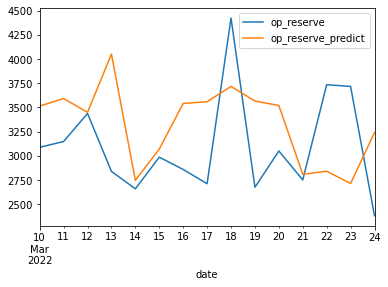

In [34]:
test_result_df.set_index('date',inplace=True)
test_result_df.plot(label='test_data') # , figsize=(16,8)

## ARIMA 整合移動平均自我迴歸模型

時間序列演算法 參考資料：https://blog.csdn.net/weixin_43861350/article/details/110008352#ARIMA__25

### 複雜版本
https://adaptable-haze-butterfly-551.medium.com/arima%E6%99%82%E9%96%93%E5%BA%8F%E5%88%97%E6%A8%A1%E5%9E%8Bpython%E6%87%89%E7%94%A8-%E9%8A%85%E5%83%B9%E6%A0%BC%E9%A0%90%E6%B8%AC-%E4%B8%80-4f91693e3ec6  

#### ETS Decomposition Models(error-trend-seasonality)

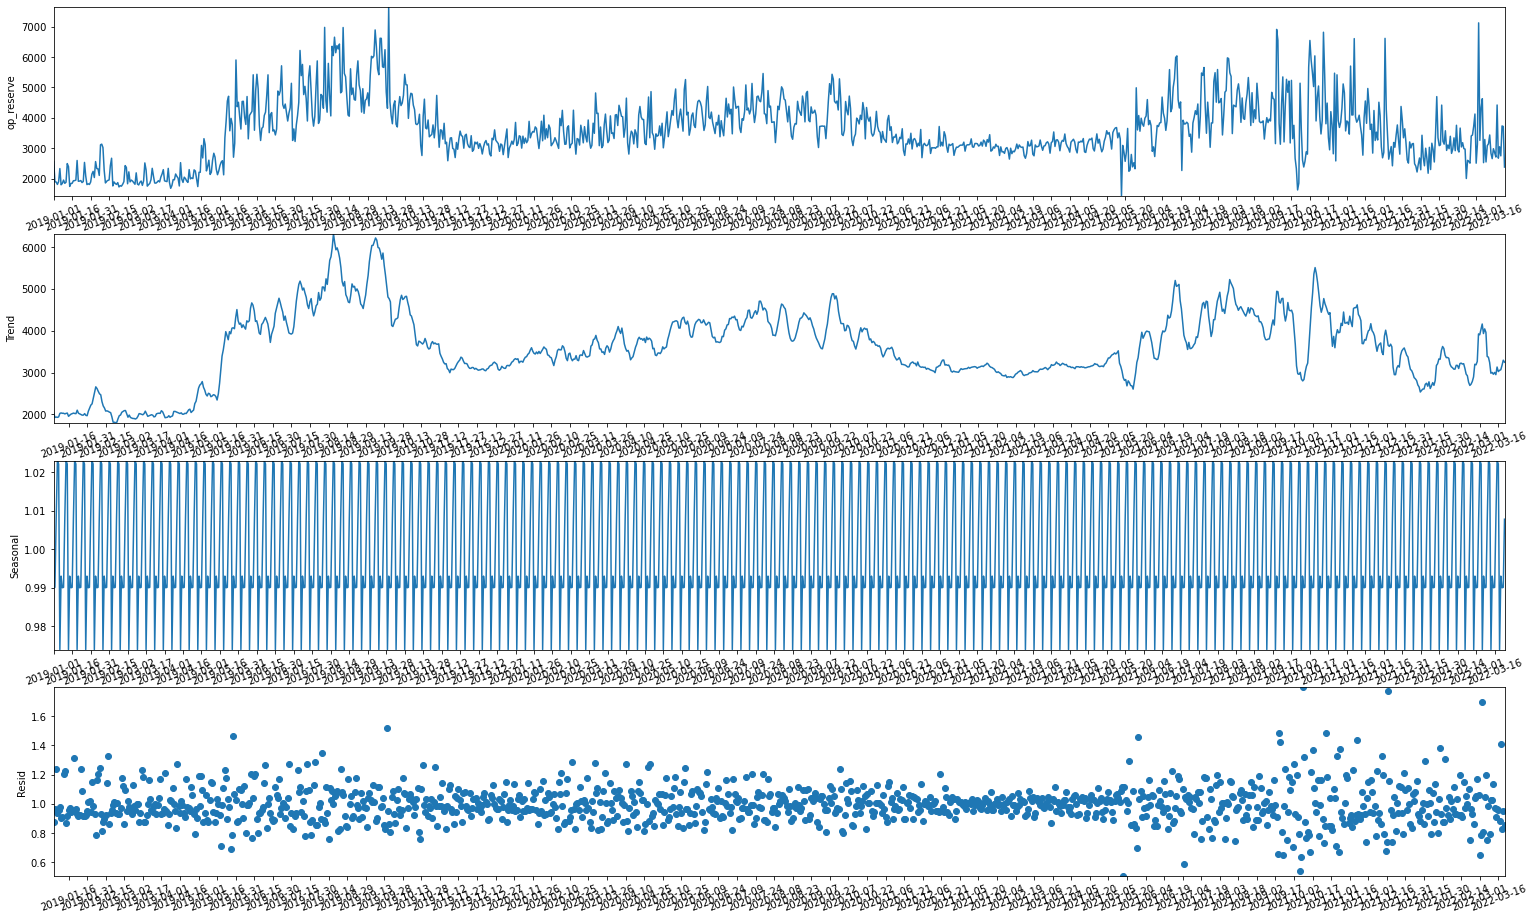

In [35]:
arima_data = raw_data['op_reserve']
# result = sm.tsa.seasonal_decompose(arima_data) # , freq=3
result = seasonal_decompose(arima_data, model="multiplicative") # , freq=3
plt.figure(figsize=(26,16))
plt.subplot(4,1,1)
plt.plot(result.observed, label="Copper Future")
plt.ylabel("op_reserve")
plt.xticks(raw_data.index[::15], rotation=20) #調整x軸刻度的呈現(每隔12個)
plt.margins(0)

plt.subplot(4,1,2)
plt.plot(result.trend)
plt.ylabel("Trend")
plt.xticks(raw_data.index[::15], rotation=20)
plt.margins(0)

plt.subplot(4,1,3)
plt.plot(result.seasonal)
plt.ylabel("Seasonal")
plt.xticks(raw_data.index[::15], rotation=20)
plt.margins(0)

plt.subplot(4,1,4)
plt.scatter(raw_data.index,result.resid)
plt.ylabel("Resid")
plt.xticks(raw_data.index[::15], rotation=20)
plt.margins(0)  #拆成四個subplot以利調整圖片間距、x軸刻度的呈現

#### 平穩性檢驗

In [36]:
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print("Results of Dickey-Fuller Test\n================================================")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(dftest[0:4], index = [
        "Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key, value in dftest[4].items():
        dfoutput["Criterical Value (%s)"%key] = value
    print(dfoutput)
    print("================================================")  
    #寫個自動判斷式
    if dfoutput[0] < dfoutput[4]:
        print("The data is stationary. (Criterical Value 1%)")  
    elif dfoutput[0] < dfoutput[5]:
        print("The data is stationary. (Criterical Value 5%)") 
    elif dfoutput[0] < dfoutput[6]:
        print("The data is stationary. (Criterical Value 10%)")
    else:
        print("The data is non-stationary, so do differencing!")
adf_test(arima_data)

Results of Dickey-Fuller Test
Test Statistic                   -2.539147
p-value                           0.106238
#Lags Used                       20.000000
Number of Observations Used    1158.000000
Criterical Value (1%)            -3.436010
Criterical Value (5%)            -2.864039
Criterical Value (10%)           -2.568101
dtype: float64
The data is non-stationary, so do differencing!


Results of Dickey-Fuller Test
Test Statistic                -1.137105e+01
p-value                        8.977719e-21
#Lags Used                     2.300000e+01
Number of Observations Used    1.154000e+03
Criterical Value (1%)         -3.436029e+00
Criterical Value (5%)         -2.864048e+00
Criterical Value (10%)        -2.568105e+00
dtype: float64
The data is stationary. (Criterical Value 1%)


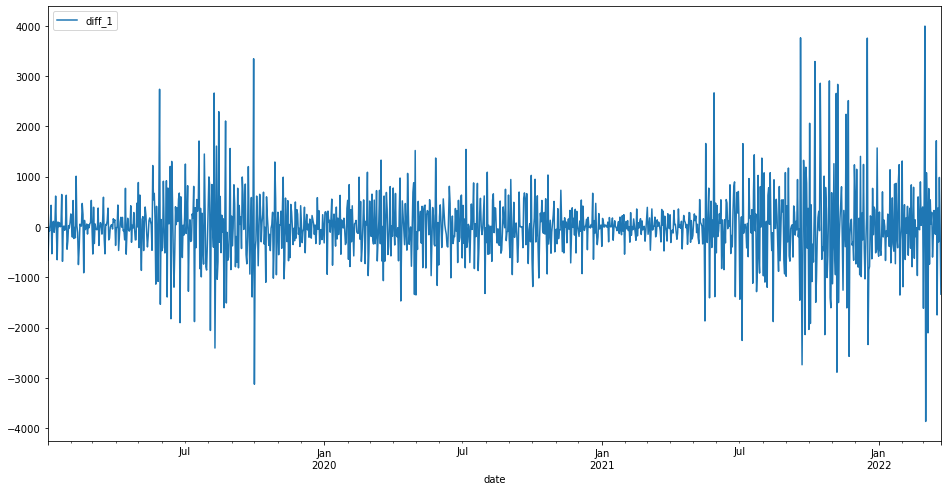

In [37]:
#一階差分 lags:1,12
diff_1 = arima_data - arima_data.shift(1) 
diff_1 = diff_1.dropna()
diff_1.head()
diff_1.plot(figsize=(16,8), label="diff_1")
plt.legend()

adf_test(diff_1)

#### 畫ACF圖與PACF圖
幫助我們判斷模型ARIMA(p, d, q)參數的選擇

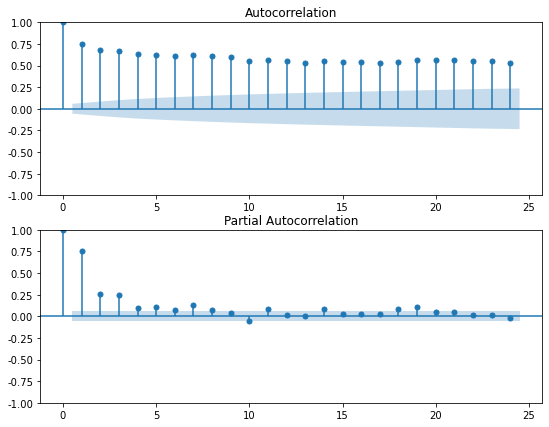

In [38]:
#correlogram
f = plt.figure(facecolor='white', figsize=(9,7))
ax1 = f.add_subplot(211)
plot_acf(arima_data, lags=24, ax=ax1)
ax2 = f.add_subplot(212)
plot_pacf(arima_data, lags=24, ax=ax2)
plt.rcParams['axes.unicode_minus'] = False 
plt.show()

ARIMA(0,1,0):AIC=18785.748743186745
ARIMA(0,1,1):AIC=18461.638052817885
ARIMA(0,1,2):AIC=18418.108442362365
ARIMA(1,1,0):AIC=18629.186384134977
ARIMA(1,1,1):AIC=18413.915653680968
ARIMA(1,1,2):AIC=18415.310453349855
ARIMA(2,1,0):AIC=18519.910728304178
ARIMA(2,1,1):AIC=18415.40115714658
ARIMA(2,1,2):AIC=18413.72976325594
ARIMA(3,1,0):AIC=18499.486529749312
ARIMA(3,1,1):AIC=18407.85289378644
ARIMA(3,1,2):AIC=18410.699995101335
This best model is pdq based on argmin AIC.


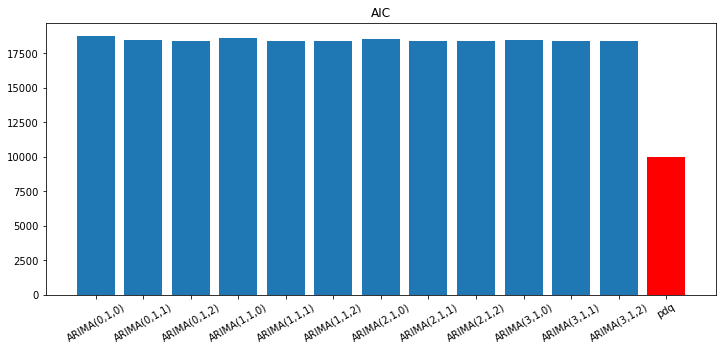

In [39]:
def arima_AIC(data, p=4, d=3, q=4):
    best_AIC =["pdq",10000]
    L =len(data)
    AIC = []
    name = []
    for i in range(p):
        for j in range(1,d):
            for k in range(q):            
                model = ARIMA(data, order=(i,j,k))
                fitted = model.fit() #disp=-1
                AIC.append(fitted.aic)
                name.append(f"ARIMA({i},{j},{k})")
                print(f"ARIMA({i},{j},{k}):AIC={fitted.aic}")
                if fitted.aic < best_AIC[1]:
                    best_AIC[0] = f"ARIMA({i},{j},{k})"
                    best_AIC[1] = fitted.aic
    print("==========================================================================")
    print(f"This best model is {best_AIC[0]} based on argmin AIC.")
    plt.figure(figsize=(12,5))
    plt.bar(name, AIC)
    plt.bar(best_AIC[0], best_AIC[1], color = "red")
    plt.xticks(rotation=30)
    plt.title("AIC")
    plt.show()
arima_AIC(arima_data, 4,2,3)

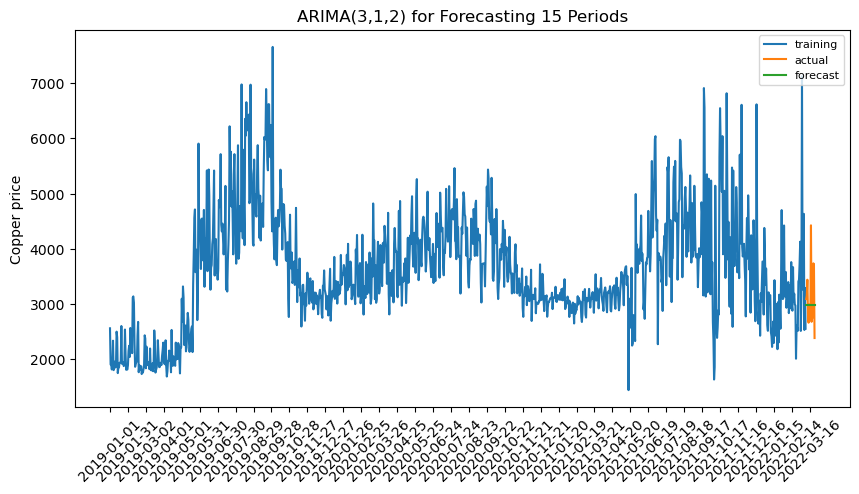

Mean Absolute Error : 382.3562951448863
Mean Squared Error : 279055.61365905654
fc_series: date
2022-03-10    2974.655573
2022-03-11    2974.655573
2022-03-12    2974.655573
2022-03-13    2974.655573
2022-03-14    2974.655573
2022-03-15    2974.655573
2022-03-16    2974.655573
2022-03-17    2974.655573
2022-03-18    2974.655573
2022-03-19    2974.655573
2022-03-20    2974.655573
2022-03-21    2974.655573
2022-03-22    2974.655573
2022-03-23    2974.655573
2022-03-24    2974.655573
dtype: float64
Copper price: date
2022-03-10    3088.0
2022-03-11    3148.0
2022-03-12    3438.0
2022-03-13    2839.0
2022-03-14    2659.0
2022-03-15    2986.0
2022-03-16    2859.0
2022-03-17    2712.0
2022-03-18    4424.0
2022-03-19    2675.0
2022-03-20    3050.0
2022-03-21    2751.0
2022-03-22    3735.0
2022-03-23    3717.0
2022-03-24    2381.0
Name: op_reserve, dtype: float64


In [40]:
#data spilt
period = 15
title = f'ARIMA(3,1,2) for Forecasting {period} Periods'
L = len(arima_data)
x_train = arima_data[:(L-period)]
x_test = arima_data[-period:]
#Build Model 
model = ARIMA(x_train, order=(3, 1, 2)) 
fitted = model.fit()# disp=-1
#Forecast
fc, se, conf,_,_,_,_,_,_,_,_,_,_,_,_ = fitted.forecast(period, alpha=0.05) # 95% conf
#Make as pandas series
fc_series = pd.Series(fc, index=x_test.index)
#Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(x_train, label='training')
plt.plot(x_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.xticks(raw_data.index[::30], rotation=45)
plt.title(title)
plt.ylabel("Copper price")
plt.legend(loc='upper right', fontsize=8)
plt.show()
#Results
print(f"Mean Absolute Error : {mean_absolute_error(fc_series,x_test)}")
print(f"Mean Squared Error : {mean_squared_error(fc_series,x_test)}")
print("===========================") 
print("fc_series:",fc_series)
print("===========================")
print("Copper price:",x_test)

### 簡易版 ARIMA 試驗
參考資料:  
- https://www.itread01.com/content/1544268486.html
- https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

In [41]:
arima_data = raw_data['op_reserve']
arima_data.head()

date
2019-01-01    2557.3
2019-01-02    1899.5
2019-01-03    1891.6
2019-01-04    1811.1
2019-01-05    1902.7
Name: op_reserve, dtype: float64

#### 只使用原始資料

In [42]:
test_count = 14

In [43]:
def predict(data,test_count):
    train, test = data[0:-test_count], data[-test_count:]
	# all the history data
	history = [x for x in train]
	predictions = []
	for t in range(test_count):
		# get the model from history data
		model = ARIMA(history, order=(3,1,2))
		# predict today op_reserve
		model_fit = model.fit()
		output = model_fit.forecast()
		yhat = output[0]
		# save result to predictions for later check correctness
		predictions.append(yhat)
		# save result to history for next day op_reserve prediction
		history.append(yhat)

		##  save predicted info to a new row in train dataframe
		# someday = train[-1:].index.values[0]
		# someday= pd.to_datetime(someday,format = '%Y-%m-%d %H:%M:%S')
		# onemore_date = someday + timedelta(days=1)
		# train.loc[onemore_date] = [round(yhat,1)]
		# print('predicted=%f, expected=%f' % (yhat, test[t]))

	predictions_df = pd.DataFrame(predictions,columns=['predicted_op_reserve'])
	# calculate the error by mse
	error = mean_squared_error(test, predictions_df)
	print('Test MSE: %.3f' % error)

	# combine the correct answer (in test), and predicted answer (in predictions_df) 
	# to result
	test = test.reset_index(level=0)
	result = pd.concat([test,predictions_df],axis=1)

	return result

TabError: inconsistent use of tabs and spaces in indentation (1466783171.py, line 4)

In [ ]:
result = predict(arima_data,test_count)
result = result.set_index('date')
result.head()
plt.xticks(rotation=25)
plt.plot(result)

#### 先使用一階差分

In [ ]:
test_count = 14

In [ ]:
def diff_predict(data,test_count):
    #一階差分 lags:1,12
    diff_1 = data.diff()
    diff_1 = diff_1.dropna()
    # all the history data after diff
    train, test = diff_1[0:-test_count], diff_1[-test_count:]
    history = [x for x in train]
    predictions = []

    for t in range(test_count):
        # get the model from history data
        model = ARIMA(history, order=(3,1,2))
        # predict the result (diff)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        # save result to predictions for later check correctness
        predictions.append(yhat)
        # save result to history for next day op_reserve diff prediction
        history.append(yhat)

        # # save predicted info to a new row in train dataframe
        # someday = train[-1:].index.values[0]
        # someday= pd.to_datetime(someday,format = '%Y-%m-%d %H:%M:%S')
        # onemore_date = someday + timedelta(days=1)
        # train.loc[onemore_date] = [round(yhat,1)]
        # print('predicted=%f, expected=%f' % (yhat, test[t]))

    # change diff to real op_reserve (need last op_reserve to calculate)
    predictions_df = pd.DataFrame(predictions,columns=['predicted_op_reserve'])
    ## first one need training dataset last one to calculate
    predictions_df.iloc[0]['predicted_op_reserve'] = predictions_df.iloc[0]['predicted_op_reserve'] + data[-len(test)-1]
    ## second and so on need front predicted_op_reserve
    for t in range(1,len(test)):
        predictions_df.iloc[t]['predicted_op_reserve'] = predictions_df.iloc[t-1]['predicted_op_reserve'] + predictions_df.iloc[t]['predicted_op_reserve']

    # save real op_reserve to real_test 
    # for later check correctness
    real_test = data[-len(test):]
    error = mean_squared_error(real_test, predictions_df)
    print('Test MSE: %.3f' % error)
    real_test = real_test.reset_index(level=0)

    # combine the correct answer (in real_test), and predicted answer (in predictions_df) 
	# to result
    result = pd.concat([real_test,predictions_df],axis=1)
    
    return result

In [ ]:
arima_data.tail()

In [ ]:
result = diff_predict(arima_data,test_count)
result = result.set_index('date')
result.head()
plt.xticks(rotation=25)
plt.plot(result)

In [ ]:
result.tail()

## SARIMA 模型


## 